In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline 
from sklearn.metrics import accuracy_score
from scipy.special import expit

df_imputed = pd.read_csv('responses.csv', sep=",")

In [ ]:
df_imputed = df_imputed.dropna()

In [ ]:
for col in ['Smoking', 'Alcohol', 'Punctuality', 'Lying', 'Internet usage',
        'Gender', 'Left - right handed', 'Education', 'Only child',
        'Village - town', 'House - block of flats']:
    df_imputed = df_imputed.drop(col,1)

In [6]:
from sklearn.model_selection import ShuffleSplit

# we want to predict the X and y data as follows:
if 'Fear of public speaking' in df_imputed:
    y = df_imputed['Fear of public speaking'].values # get the labels we want
    del df_imputed['Fear of public speaking'] # get rid of the class label
    X = df_imputed.values # use everything else to predict!

num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(
                         n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None)


In [9]:
%%time
# from last time, our logistic regression algorithm is given by (including everything we previously had):
class BinaryLogisticRegression:
    def __init__(self, eta, iterations=20, C=0.001):
        self.eta = eta
        self.iters = iterations
        self.C = C
        # internally we will store the weights as self.w_ to keep with sklearn conventions
        
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'Binary Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained Binary Logistic Regression Object'
        
    # convenience, private:
    @staticmethod
    def _add_bias(X):
        return np.hstack((np.ones((X.shape[0],1)),X)) # add bias term
    
    @staticmethod
    def _sigmoid(theta):
        # increase stability, redefine sigmoid operation
        return expit(theta) #1/(1+np.exp(-theta))
    
    # vectorized gradient calculation with regularization using L2 Norm
    def _get_gradient(self,X,y):
        ydiff = y-self.predict_proba(X,add_bias=False).ravel() # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        
        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += 2 * self.w_[1:] * self.C
        
        return gradient
    
    # public:
    def predict_proba(self,X,add_bias=True):
        # add bias term if requested
        Xb = self._add_bias(X) if add_bias else X
        return self._sigmoid(Xb @ self.w_) # return the probability y=1
    
    def predict(self,X):
        return (self.predict_proba(X)>0.5) #return the actual prediction
    
    
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros
        
        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = self._get_gradient(Xb,y)
            self.w_ += gradient*self.eta # multiply by learning rate 

blr = BinaryLogisticRegression(eta=0.1,iterations=500,C=0.001)

blr.fit(X,y)
print(blr)

yhat = blr.predict(X)
print('Accuracy of: ',accuracy_score(y,yhat+1))

Binary Logistic Regression Object with coefficients:
[[    90.77700297]
 [   455.69584136]
 [   310.12282053]
 [   296.38078132]
 [   214.42342046]
 [   201.30932795]
 [   284.12760523]
 [   263.20815517]
 [   333.14489982]
 [   364.99230948]
 [   228.86059827]
 [   241.9717399 ]
 [   274.68285292]
 [   264.37882356]
 [   260.24370786]
 [   300.44206565]
 [   277.56896059]
 [   265.78549451]
 [   220.90069261]
 [   206.92855259]
 [   442.66107212]
 [   260.16446656]
 [   325.49531991]
 [   430.09429155]
 [   335.33045895]
 [   298.48972215]
 [   297.55702358]
 [   364.28971172]
 [   368.65984636]
 [   343.53062955]
 [   193.1951201 ]
 [   335.3350492 ]
 [   301.30380176]
 [   295.91607141]
 [   236.5990918 ]
 [   226.2106571 ]
 [   194.13126135]
 [   401.21182102]
 [   294.74523909]
 [   246.5078163 ]
 [   257.8183756 ]
 [   205.99101786]
 [   310.03972669]
 [   295.91459597]
 [   363.12174831]
 [   239.86763523]
 [   198.50729774]
 [   246.35113701]
 [   250.71823881]
 [   211.5350996

In [27]:
%%time
from numpy.linalg import pinv
class HessianBinaryLogisticRegression(BinaryLogisticRegression):
    # just overwrite gradient function
    def _get_gradient(self,X,y):
        g = self.predict_proba(X,add_bias=False).ravel() # get sigmoid value for all classes
        hessian = X.T @ np.diag(g*(1-g)) @ X + 2 * self.C # calculate the hessian

        ydiff = y-g # get y difference
        gradient = np.sum(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += 2 * self.w_[1:] * self.C
        
        return pinv(hessian) @ gradient
       
hlr = HessianBinaryLogisticRegression(eta=0.1,iterations=20,C=0.1) # note that we need only a few iterations here

hlr.fit(X,y)
yhat = hlr.predict(X)
print(hlr)
print('Accuracy of: ',accuracy_score(y,yhat+1))

Binary Logistic Regression Object with coefficients:
[[  2.45027462e+170]
 [ -1.31939092e+172]
 [  2.62226614e+171]
 [  2.69990104e+171]
 [ -8.10370053e+170]
 [ -1.25622611e+171]
 [  2.52865447e+176]
 [ -2.48917192e+175]
 [ -1.88031351e+175]
 [ -3.20587632e+175]
 [ -1.06333001e+176]
 [ -6.19847138e+174]
 [ -3.08920150e+174]
 [ -1.23578703e+174]
 [  8.72544465e+173]
 [ -2.69228095e+173]
 [ -5.04004842e+173]
 [ -4.94630900e+173]
 [ -4.94630900e+173]
 [ -4.94630900e+173]
 [ -4.94630900e+173]
 [ -4.94630900e+173]
 [ -4.94630900e+173]
 [ -4.94630900e+173]
 [ -4.94630900e+173]
 [ -4.94630900e+173]
 [ -4.94630900e+173]
 [ -4.94630900e+173]
 [ -4.94630900e+173]
 [ -4.94630900e+173]
 [ -4.94630900e+173]
 [ -4.94630900e+173]
 [ -4.94630900e+173]
 [ -4.94630900e+173]
 [ -4.94630900e+173]
 [ -4.94630900e+173]
 [ -4.94630900e+173]
 [ -4.94630900e+173]
 [ -4.94630900e+173]
 [ -4.94630900e+173]
 [ -4.94630900e+173]
 [ -4.94630900e+173]
 [ -4.94630900e+173]
 [ -4.94630900e+173]
 [ -4.94630900e+173]
 [

In [31]:
%%time
# for this, we won't perform our own BFGS implementation 
# (it takes a good deal of code and understanding of the algorithm)
# luckily for us, scipy has its own BFGS implementation:
from scipy.optimize import fmin_bfgs
class BFGSBinaryLogisticRegression(BinaryLogisticRegression):
    
    @staticmethod
    def objective_function(w,X,y,C):
        g = expit(X @ w)
        return -np.sum(np.log(g[y==1]))-np.sum(np.log(1-g[y==0])) + C*sum(w**2) #-np.sum(y*np.log(g)+(1-y)*np.log(1-g))

    @staticmethod
    def objective_gradient(w,X,y,C):
        g = expit(X @ w)
        ydiff = y-g # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0)
        gradient = gradient.reshape(w.shape)
        gradient[1:] += 2 * w[1:] * C
        return -gradient
    
    # just overwrite fit function
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = fmin_bfgs(self.objective_function, # what to optimize
                            np.zeros((num_features,1)), # starting point
                            fprime=self.objective_gradient, # gradient function
                            args=(Xb,y,self.C), # extra args for gradient and objective function
                            gtol=1e-03, # stopping criteria for gradient, |v_k|
                            maxiter=self.iters, # stopping criteria iterations
                            disp=False)
        
        self.w_ = self.w_.reshape((num_features,1))
            
bfgslr = BFGSBinaryLogisticRegression(_,2) # note that we need only a few iterations here

bfgslr.fit(X,y)
yhat = bfgslr.predict(X)
print(bfgslr)
print('Accuracy of: ',accuracy_score(y,yhat+1))

Binary Logistic Regression Object with coefficients:
[[ 0.0053308 ]
 [ 0.02543407]
 [ 0.01737123]
 [ 0.01652036]
 [ 0.0119943 ]
 [ 0.01125106]
 [ 0.0158728 ]
 [ 0.01470071]
 [ 0.0185587 ]
 [ 0.02034076]
 [ 0.0127307 ]
 [ 0.01341243]
 [ 0.01534826]
 [ 0.01476222]
 [ 0.01457085]
 [ 0.01679544]
 [ 0.01546786]
 [ 0.01487498]
 [ 0.01232577]
 [ 0.01154665]
 [ 0.02472159]
 [ 0.01454181]
 [ 0.01813156]
 [ 0.0240279 ]
 [ 0.01868001]
 [ 0.01666729]
 [ 0.01669805]
 [ 0.02029976]
 [ 0.02052187]
 [ 0.01922505]
 [ 0.01087517]
 [ 0.01877569]
 [ 0.01690821]
 [ 0.01656991]
 [ 0.01338851]
 [ 0.01266578]
 [ 0.01091618]
 [ 0.02238595]
 [ 0.01650498]
 [ 0.01384812]
 [ 0.01431969]
 [ 0.0114766 ]
 [ 0.01726188]
 [ 0.01653915]
 [ 0.02029463]
 [ 0.0133663 ]
 [ 0.01126132]
 [ 0.01382762]
 [ 0.01398652]
 [ 0.01182857]
 [ 0.019413  ]
 [ 0.01248125]
 [ 0.01196867]
 [ 0.00996621]
 [ 0.01791798]
 [ 0.01666388]
 [ 0.01015415]
 [ 0.01263844]
 [ 0.0174242 ]
 [ 0.01723113]
 [ 0.01592406]
 [ 0.02409112]
 [ 0.01498263]
 [

In [28]:
class MultiClassLogisticRegression:
    def __init__(self, eta, iterations=20, C=0.0001):
        self.eta = eta
        self.iters = iterations
        self.C = C
        self.classifiers_ = []
        # internally we will store the weights as self.w_ to keep with sklearn conventions
    
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'MultiClass Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained MultiClass Logistic Regression Object'
        
    def fit(self,X,y):
        num_samples, num_features = X.shape
        self.unique_ = np.sort(np.unique(y)) # get each unique class value
        num_unique_classes = len(self.unique_)
        self.classifiers_ = []
        for i,yval in enumerate(self.unique_): # for each unique value
            y_binary = y==yval # create a binary problem
            # train the binary classifier for this class
            hblr = HessianBinaryLogisticRegression(self.eta,self.iters,self.C)
            hblr.fit(X,y_binary)
            #print(accuracy(y_binary,hblr.predict(X)))
            # add the trained classifier to the list
            self.classifiers_.append(hblr)
            
        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T
        
    def predict_proba(self,X):
        probs = []
        for hblr in self.classifiers_:
            probs.append(hblr.predict_proba(X).reshape((len(X),1))) # get probability for each classifier
        
        return np.hstack(probs) # make into single matrix
    
    def predict(self,X):
        return np.argmax(self.predict_proba(X),axis=1) # take argmax along row
    



In [29]:
%%time
lr = MultiClassLogisticRegression(eta=0.1,iterations=10,C=0.0001)
lr.fit(X,y)
print(lr)

yhat = lr.predict(X)
print('Accuracy of: ',accuracy_score(y,yhat+1))

MultiClass Logistic Regression Object with coefficients:
[[ -3.21706244e+00   2.34172561e-02   6.63592728e-02   3.16253335e-02
   -2.77161794e-02   2.73993499e-02   6.71017765e-02  -3.80480362e-02
    2.24731870e-02   1.00764495e-01  -3.41310432e-02  -7.53741169e-02
   -8.88313083e-02   6.28952354e-02  -7.61642514e-02   2.41592043e-03
   -1.17151137e-02  -1.26963453e-02  -3.87819335e-02  -4.35865594e-02
   -9.21133278e-02   6.22405342e-02  -1.54863995e-01   1.28738628e-01
    1.78465088e-02  -2.71500022e-02   2.37307712e-03   2.10742002e-02
   -6.22611823e-02  -5.92794663e-02   7.54948006e-03   1.88119046e-03
    3.39335146e-02   3.71593252e-02  -2.61382559e-02   1.96259661e-02
   -3.89869688e-02  -3.28651004e-02   8.00792579e-02   7.79963818e-03
   -6.12550020e-02  -2.34705061e-03   3.37893317e-02  -7.69752796e-03
   -4.65539728e-02  -1.90173488e-02   8.53542415e-02  -2.59244334e-02
    2.94037088e-02   4.73827500e-02  -9.75182329e-02  -3.31325185e-02
    5.10387086e-02  -3.62618843e-

In [24]:
# linear boundaries visualization from sklearn documentation
from matplotlib import pyplot as plt
import copy
%matplotlib inline

def plot_decision_boundaries(lr,Xin,y,title=''):
    Xb = copy.deepcopy(Xin)
    lr.fit(Xb[:,:2],y) # train only on two features

    h=0.01
    # create a mesh to plot in
    x_min, x_max = Xb[:, 0].min() - 1, Xb[:, 0].max() + 1
    y_min, y_max = Xb[:, 1].min() - 1, Xb[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # get prediction values
    Z = lr.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.5)

    # Plot also the training points
    plt.scatter(Xb[:, 0], Xb[:, 1], c=y, cmap=plt.cm.Paired)
    plt.xlabel('Feature')
    plt.ylabel('Fear of Public Speaking')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(title)
    plt.show()


In [18]:
X

array([[   5.,    3.,    2., ...,  163.,   48.,    1.],
       [   4.,    4.,    2., ...,  163.,   58.,    2.],
       [   5.,    5.,    2., ...,  176.,   67.,    2.],
       ..., 
       [   4.,    3.,    1., ...,  173.,   75.,    0.],
       [   5.,    3.,    3., ...,  173.,   58.,    1.],
       [   5.,    5.,    4., ...,  185.,   72.,    1.]])

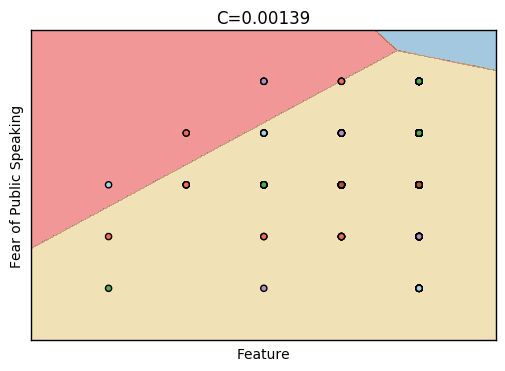

In [30]:
from ipywidgets import widgets as wd

cost_vals = np.logspace(-3,-2,15)
def lr_explor(cost_idx):
    C = cost_vals[cost_idx]
    lr_clf = MultiClassLogisticRegression(eta=0.1,
                                           iterations=2500,
                                           C=C) # get object
    
    plot_decision_boundaries(lr_clf,X,y,title="C=%.5f"%(C))

wd.interact(lr_explor,cost_idx=(0,15,1),__manual=True)

In [34]:
%%time
from sklearn.linear_model import LogisticRegression as SKLogisticRegression

lr_sk = SKLogisticRegression() # all params default
lr_sk.fit(X,y)
# print(np.hstack((lr_sk.intercept_[:,np.newaxis],lr_sk.coef_)))
# yhat = lr_sk.predict(X)
print('Accuracy of: ',accuracy_score(y,yhat))

Accuracy of:  0.685459940653
CPU times: user 113 ms, sys: 2.4 ms, total: 116 ms
Wall time: 114 ms
